# Chapter 10: Deep Learning Game Strategies

New Skills in This Chapter:

• Setting up the OpenAI Gym game environment

• Generating training data by simulating games

• Designing game strategies using deep neural networks

• Testing the efficacy of game strategies

***
*Play is the highest form of research.*
***
-- Albert Einstein

***

In [1]:
import os

os.makedirs("files/ch10", exist_ok=True)

# 10.1 Get Started with the OpenAI Gym Environment


In [2]:
!pip install gym==0.15.7

***
$\mathbf{\text{Python package version control}}$<br>
***
There are newer versions of OpenAI gym, but they are not compatible with Baselines, a package that we need to train Breakout and other Atari games (such as Space Invaders, Seaquest, Beam Rider).

In case you accidentally installed a different version, run the following lines of code to correct it, with your virtual environment activated.

`pip uninstall gym`

`pip install gym==0.15.7`

***

## 10.1.1 Basic Elements of A Game Environment


## 10.1.2 The Frozen Lake Game 

The agent moves on the surface of a frozen lake, which is simplified as a 4 by 4 grid. The agent starts at the top left corner and tries to get to the lower right corner, without falling into one of the four holes on the frozen lake. The conditions of the lake surface are as follows:
<img src="https://gattonweb.uky.edu/faculty/lium/ml/frozen_t.png" />

In [3]:
import gym 
 
env=gym.make("FrozenLake-v0",is_slippery=False)
env.reset()                    
env.render()


SFFF
FHFH
FFFH
HFFG


In [4]:
# Print out all possible actions in this game
actions=env.action_space
print(f"The action space in Frozen Lake is {actions}")
# Print out all possible states in this game
states=env.observation_space
print(f"The state space in Frozen Lake is {states}")

The action space in Frozen Lake is Discrete(4)
The state space in Frozen Lake is Discrete(16)


The action space in the Frozenlake game has four values: 0, 1, 2, and 3, with the following meanings:
* 0: Going left
* 1: Going down
* 2: Going right
* 3: Going up

The state space in the Frozenlake game has 16 values: 0, 1, 2, …, 15. The top left square is state 0, the top right is state 3, and the bottom right corner is 15, as shown in the following picture:
<img src="https://gattonweb.uky.edu/faculty/lium/ml/lakesurface.png" />

You can play a complete game as follows:

In [5]:
while True:
    action=actions.sample()
    print(action)
    new_state,reward,done,info=env.step(action)
    env.render()
    print(new_state,reward,done,info)    
    if done==True:
        break

1
  (Down)
SFFF
FHFH
FFFH
HFFG
4 0.0 False {'prob': 1.0}
1
  (Down)
SFFF
FHFH
FFFH
HFFG
8 0.0 False {'prob': 1.0}
2
  (Right)
SFFF
FHFH
FFFH
HFFG
9 0.0 False {'prob': 1.0}
3
  (Up)
SFFF
FHFH
FFFH
HFFG
5 0.0 True {'prob': 1.0}


## 10.1.3 Play the Frozen Lake Game Manually

In [6]:
print('''
enter 0 for left, 1 for down
2 for right, and 3 for up
''')
env.reset()                    
env.render()
while True:
    try:
        action=int(input('how do you want to move?\n'))
        new_state,reward,done,_=env.step(action)
        env.render()
        if done==True:
            if new_state==15:
                print("Congrats, you won!")
            else:
                print("Better luck next time!")
            break          
        
    except:
        print('please enter 0, 1, 2, or 3')


enter 0 for left, 1 for down
2 for right, and 3 for up


SFFF
FHFH
FFFH
HFFG
how do you want to move?
1
  (Down)
SFFF
FHFH
FFFH
HFFG
how do you want to move?
1
  (Down)
SFFF
FHFH
FFFH
HFFG
how do you want to move?
2
  (Right)
SFFF
FHFH
FFFH
HFFG
how do you want to move?
2
  (Right)
SFFF
FHFH
FFFH
HFFG
how do you want to move?
1
  (Down)
SFFF
FHFH
FFFH
HFFG
how do you want to move?
2
  (Right)
SFFF
FHFH
FFFH
HFFG
Congrats, you won!


# 10.2 Deep Learning Game Strategies: Generating Data


## 10.2.2 Simulate One Game


In [7]:
import numpy as np

# Define one_game() function
def one_game():
    # create lists to record game history and outcome 
    history=[]
    winlose=[0]    
    # start the game
    state=env.reset()
    while True:
        # randomly choose an action  
        action=env.action_space.sample()
        # make a move
        new_state,reward,done,_=env.step(action)
        # recording game hisotry
        history.append([state,action,new_state,reward,done])
        # prepare for the next round
        state=new_state
        # stop if the game is over
        if done==True:
            # if end up in state 15, change outcome to 1
            if new_state==15:
                winlose[0]=1
            break     
    return history, winlose
# Play one game
history,outcome=one_game()
print(history) 
print(outcome)  

[[0, 1, 4, 0.0, False], [4, 1, 8, 0.0, False], [8, 3, 4, 0.0, False], [4, 1, 8, 0.0, False], [8, 3, 4, 0.0, False], [4, 0, 4, 0.0, False], [4, 0, 4, 0.0, False], [4, 2, 5, 0.0, True]]
[0]


## 10.2.3 Simulate Many Games

In [8]:
histories=[]
outcomes=[]
# Play 10,000 games
for i in range(10000):
    history,outcome=one_game()
    # record history and outcome
    histories.append(history)
    outcomes.append(outcome)

Next, we'll save the simulated data on the computer for later use. We can use the ***pickle*** library to do that. The ***pickle*** library is in the Python Standard Library so it comes with Python installation on your computer. No manual installation is needed. 

In [9]:
import pickle
# save the simulation data on your computer
with open('files/ch10/frozen_games.pickle', 'wb') as fp:
    pickle.dump((histories, outcomes), fp)

You can load up the saved simulation data from your computer, and print out the first five games. 

In [10]:
# read the data and print out the first 10 games
with open('files/ch10/frozen_games.pickle', 'rb') as fp:
    histories, outcomes=pickle.load(fp)
    
from pprint import pprint
pprint(histories[:5])    
pprint(outcomes[:5])  

[[[0, 1, 4, 0.0, False], [4, 2, 5, 0.0, True]],
 [[0, 2, 1, 0.0, False],
  [1, 0, 0, 0.0, False],
  [0, 3, 0, 0.0, False],
  [0, 1, 4, 0.0, False],
  [4, 2, 5, 0.0, True]],
 [[0, 0, 0, 0.0, False],
  [0, 3, 0, 0.0, False],
  [0, 2, 1, 0.0, False],
  [1, 2, 2, 0.0, False],
  [2, 3, 2, 0.0, False],
  [2, 2, 3, 0.0, False],
  [3, 2, 3, 0.0, False],
  [3, 3, 3, 0.0, False],
  [3, 3, 3, 0.0, False],
  [3, 2, 3, 0.0, False],
  [3, 0, 2, 0.0, False],
  [2, 2, 3, 0.0, False],
  [3, 0, 2, 0.0, False],
  [2, 0, 1, 0.0, False],
  [1, 3, 1, 0.0, False],
  [1, 3, 1, 0.0, False],
  [1, 2, 2, 0.0, False],
  [2, 0, 1, 0.0, False],
  [1, 0, 0, 0.0, False],
  [0, 2, 1, 0.0, False],
  [1, 2, 2, 0.0, False],
  [2, 0, 1, 0.0, False],
  [1, 3, 1, 0.0, False],
  [1, 3, 1, 0.0, False],
  [1, 2, 2, 0.0, False],
  [2, 1, 6, 0.0, False],
  [6, 1, 10, 0.0, False],
  [10, 1, 14, 0.0, False],
  [14, 3, 10, 0.0, False],
  [10, 2, 11, 0.0, True]],
 [[0, 1, 4, 0.0, False],
  [4, 0, 4, 0.0, False],
  [4, 1, 8, 0.0, Fal

# 10.3 Train the Deep Neural Network


## 10.3.1 Preprocess the Data

In the next few sections, you’ll learn how to convert the game history and outcome data into a form that the computer understands before you feed them into the deep neural network.

We'll associate each state-action pair with the final game outcome so that the model can estimate the probability of winning for each state-action combination. We'll use the first game above as an example. In the first game, the outcome is 0, meaning the player lost the game. There are 16 steps in game 1, so we'll create 16 values of X and y, as follows. 

In [11]:
game1_history = histories[0]  
game1_outcome = outcomes[0]     
# Print out each state-action pair
for i in game1_history:
    print(i)

[0, 1, 4, 0.0, False]
[4, 2, 5, 0.0, True]


In [12]:
# Create empty X and y lists
game1_X, game1_y = [], []    
# Create X and y for each game step
for i in game1_history:
    game1_X.append([i[0], i[1]])
    game1_y.append(game1_outcome)
# Print out X, y
pprint(game1_X)
pprint(game1_y)

[[0, 1], [4, 2]]
[[0], [0]]


In [13]:
# Define a onehot_encoder() function
def onehot_encoder(value, length):
    onehot=np.zeros((1,length))
    onehot[0,value]=1
    return onehot
# Change state and action into onehot_encoders
game1onehot_X=[]
for s, a in game1_X:
    print(s,a)
    onehot_s=onehot_encoder(s, 16)
    onehot_a=onehot_encoder(a, 4)
    sa=np.concatenate([onehot_s,onehot_a],axis=1)
    game1onehot_X.append(sa.reshape(-1,))  
# Print out new X
pprint(game1onehot_X)

0 1
4 2
[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0.])]


In [14]:
# Create empty X and y lists
X,y=[],[]    
# Create X and y for each game step
for gamei, yi in zip(histories, outcomes):
    for step in gamei:
        s,a=step[0], step[1]
        onehot_s=onehot_encoder(s, 16)
        onehot_a=onehot_encoder(a, 4)
        sa=np.concatenate([onehot_s,onehot_a],axis=1)
        X.append(sa.reshape(-1,))
        y.append(yi)

## 10.3.2 Train Deep Learning Game Strategies


In [15]:
from tensorflow.keras.models import Sequential
from random import choice
import pickle
from tensorflow.keras.layers import Dense
import numpy as np
from pprint import pprint

X = np.array(X).reshape((-1, 20))
y = np.array(y).reshape((-1, 1))
# Create a model
model = Sequential()
model.add(Dense(128,activation='relu',
                input_shape=(20,)))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',
                   optimizer='adam', 
                   metrics=['accuracy'])
# Train the model for 50 epochs
model.fit(X,y,epochs=50,verbose=0)
model.save('files/ch10/trained_frozen.h5')

# 10.4 Play Games with the Trained Model

## 10.4.1 Test One Game


In [16]:
action0=onehot_encoder(0, 4)
action1=onehot_encoder(1, 4)
action2=onehot_encoder(2, 4)
action3=onehot_encoder(3, 4)
# save the predictions in each step
predictions=[]
state=env.reset()
env.render()
while True:
    # Convert state and action into onehots 
    state_arr=onehot_encoder(state, 16)
    # Predict the probability of winning 
    sa0=np.concatenate([state_arr,action0],axis=1)    
    sa1=np.concatenate([state_arr,action1],axis=1)  
    sa2=np.concatenate([state_arr,action2],axis=1)  
    sa3=np.concatenate([state_arr,action3],axis=1)
    sa=np.concatenate([sa0,sa1,sa2,sa3],axis=0)
    prediction=model.predict(sa)
    action=np.argmax(prediction)
    predictions.append(prediction)
    print(action)
    new_state,reward,done,info=env.step(action)
    env.render()
    print(new_state,reward,done,info) 
    state=new_state
    if done==True:
        break


SFFF
FHFH
FFFH
HFFG
1/1 [==============================] - 0s 71ms/step
1
  (Down)
SFFF
FHFH
FFFH
HFFG
4 0.0 False {'prob': 1.0}
1/1 [==============================] - 0s 18ms/step
1
  (Down)
SFFF
FHFH
FFFH
HFFG
8 0.0 False {'prob': 1.0}
1/1 [==============================] - 0s 18ms/step
2
  (Right)
SFFF
FHFH
FFFH
HFFG
9 0.0 False {'prob': 1.0}
1/1 [==============================] - 0s 19ms/step
1
  (Down)
SFFF
FHFH
FFFH
HFFG
13 0.0 False {'prob': 1.0}
1/1 [==============================] - 0s 19ms/step
2
  (Right)
SFFF
FHFH
FFFH
HFFG
14 0.0 False {'prob': 1.0}
1/1 [==============================] - 0s 19ms/step
2
  (Right)
SFFF
FHFH
FFFH
HFFG
15 1.0 True {'prob': 1.0}


In [17]:
with open('files/ch10/frozen_predictions.p','wb') as fp:
    pickle.dump(predictions,fp)

## 10.4.2 Test the Efficacy of the Game Strategy


In [18]:
from utils.ch10util import test_one_game

winloses = []
for i in range(1000):
    winlose = test_one_game()
    winloses.append(winlose)
# Print out the number of winning games
wins = winloses.count(1)
print("the number of winning games is", wins)
# Print out the number of losing games
losses = winloses.count(0)
print("the number of losing games is", losses)

the number of winning games is 1000
the number of losing games is 0


# 10.5 Animate the Decision Process
 

## 10.5.1 Generate Figures


In [19]:
from utils.ch10util import frozen_lake_steps

# Call the function to generate pictures
frozen_lake_steps()

If you open the file frozen_stage0step1.png, you'll see the following:
<img src="https://gattonweb.uky.edu/faculty/lium/ml/frozen_stage0step1.png" />which is the starting position of the agent. The file frozen_stage0step2.png below:
<img src="https://gattonweb.uky.edu/faculty/lium/ml/frozen_stage0step2.png" /> shows the probabilities of winning the game for the four possible actions: left, down, right, and up. The file frozen_stage0step3.png below:
<img src="https://gattonweb.uky.edu/faculty/lium/ml/frozen_stage0step3.png" /> highlights action with the greatest probability of winning the game, which is down. That's the action the agent chooses in the first stage of the game.


## 10.5.2 Create the Animation


In [20]:
import imageio, PIL

frames=[]
for stage in range(6):
    for step in range(3):
        file=f"files/ch10/frozen_stage{stage}step{step+1}.png"
        frame=PIL.Image.open(file)   
        frame=np.asarray(frame)
        frames.append(np.array(frame))
frame=PIL.Image.open(f"files/ch10/frozen_stage6step1.png")   
frame=np.asarray(frame)
# put three frames at the end to highlight the game result
frames.append(np.array(frame))        
frames.append(np.array(frame)) 
frames.append(np.array(frame)) 
imageio.mimsave('files/ch10/frozen_stages.gif',frames,duration=500)

The animation looks as follows:
<img src="https://gattonweb.uky.edu/faculty/lium/ml/frozen_stages.gif" />

## 10.5.3 Create A Figure with Subplots
We can create a figure with subplots

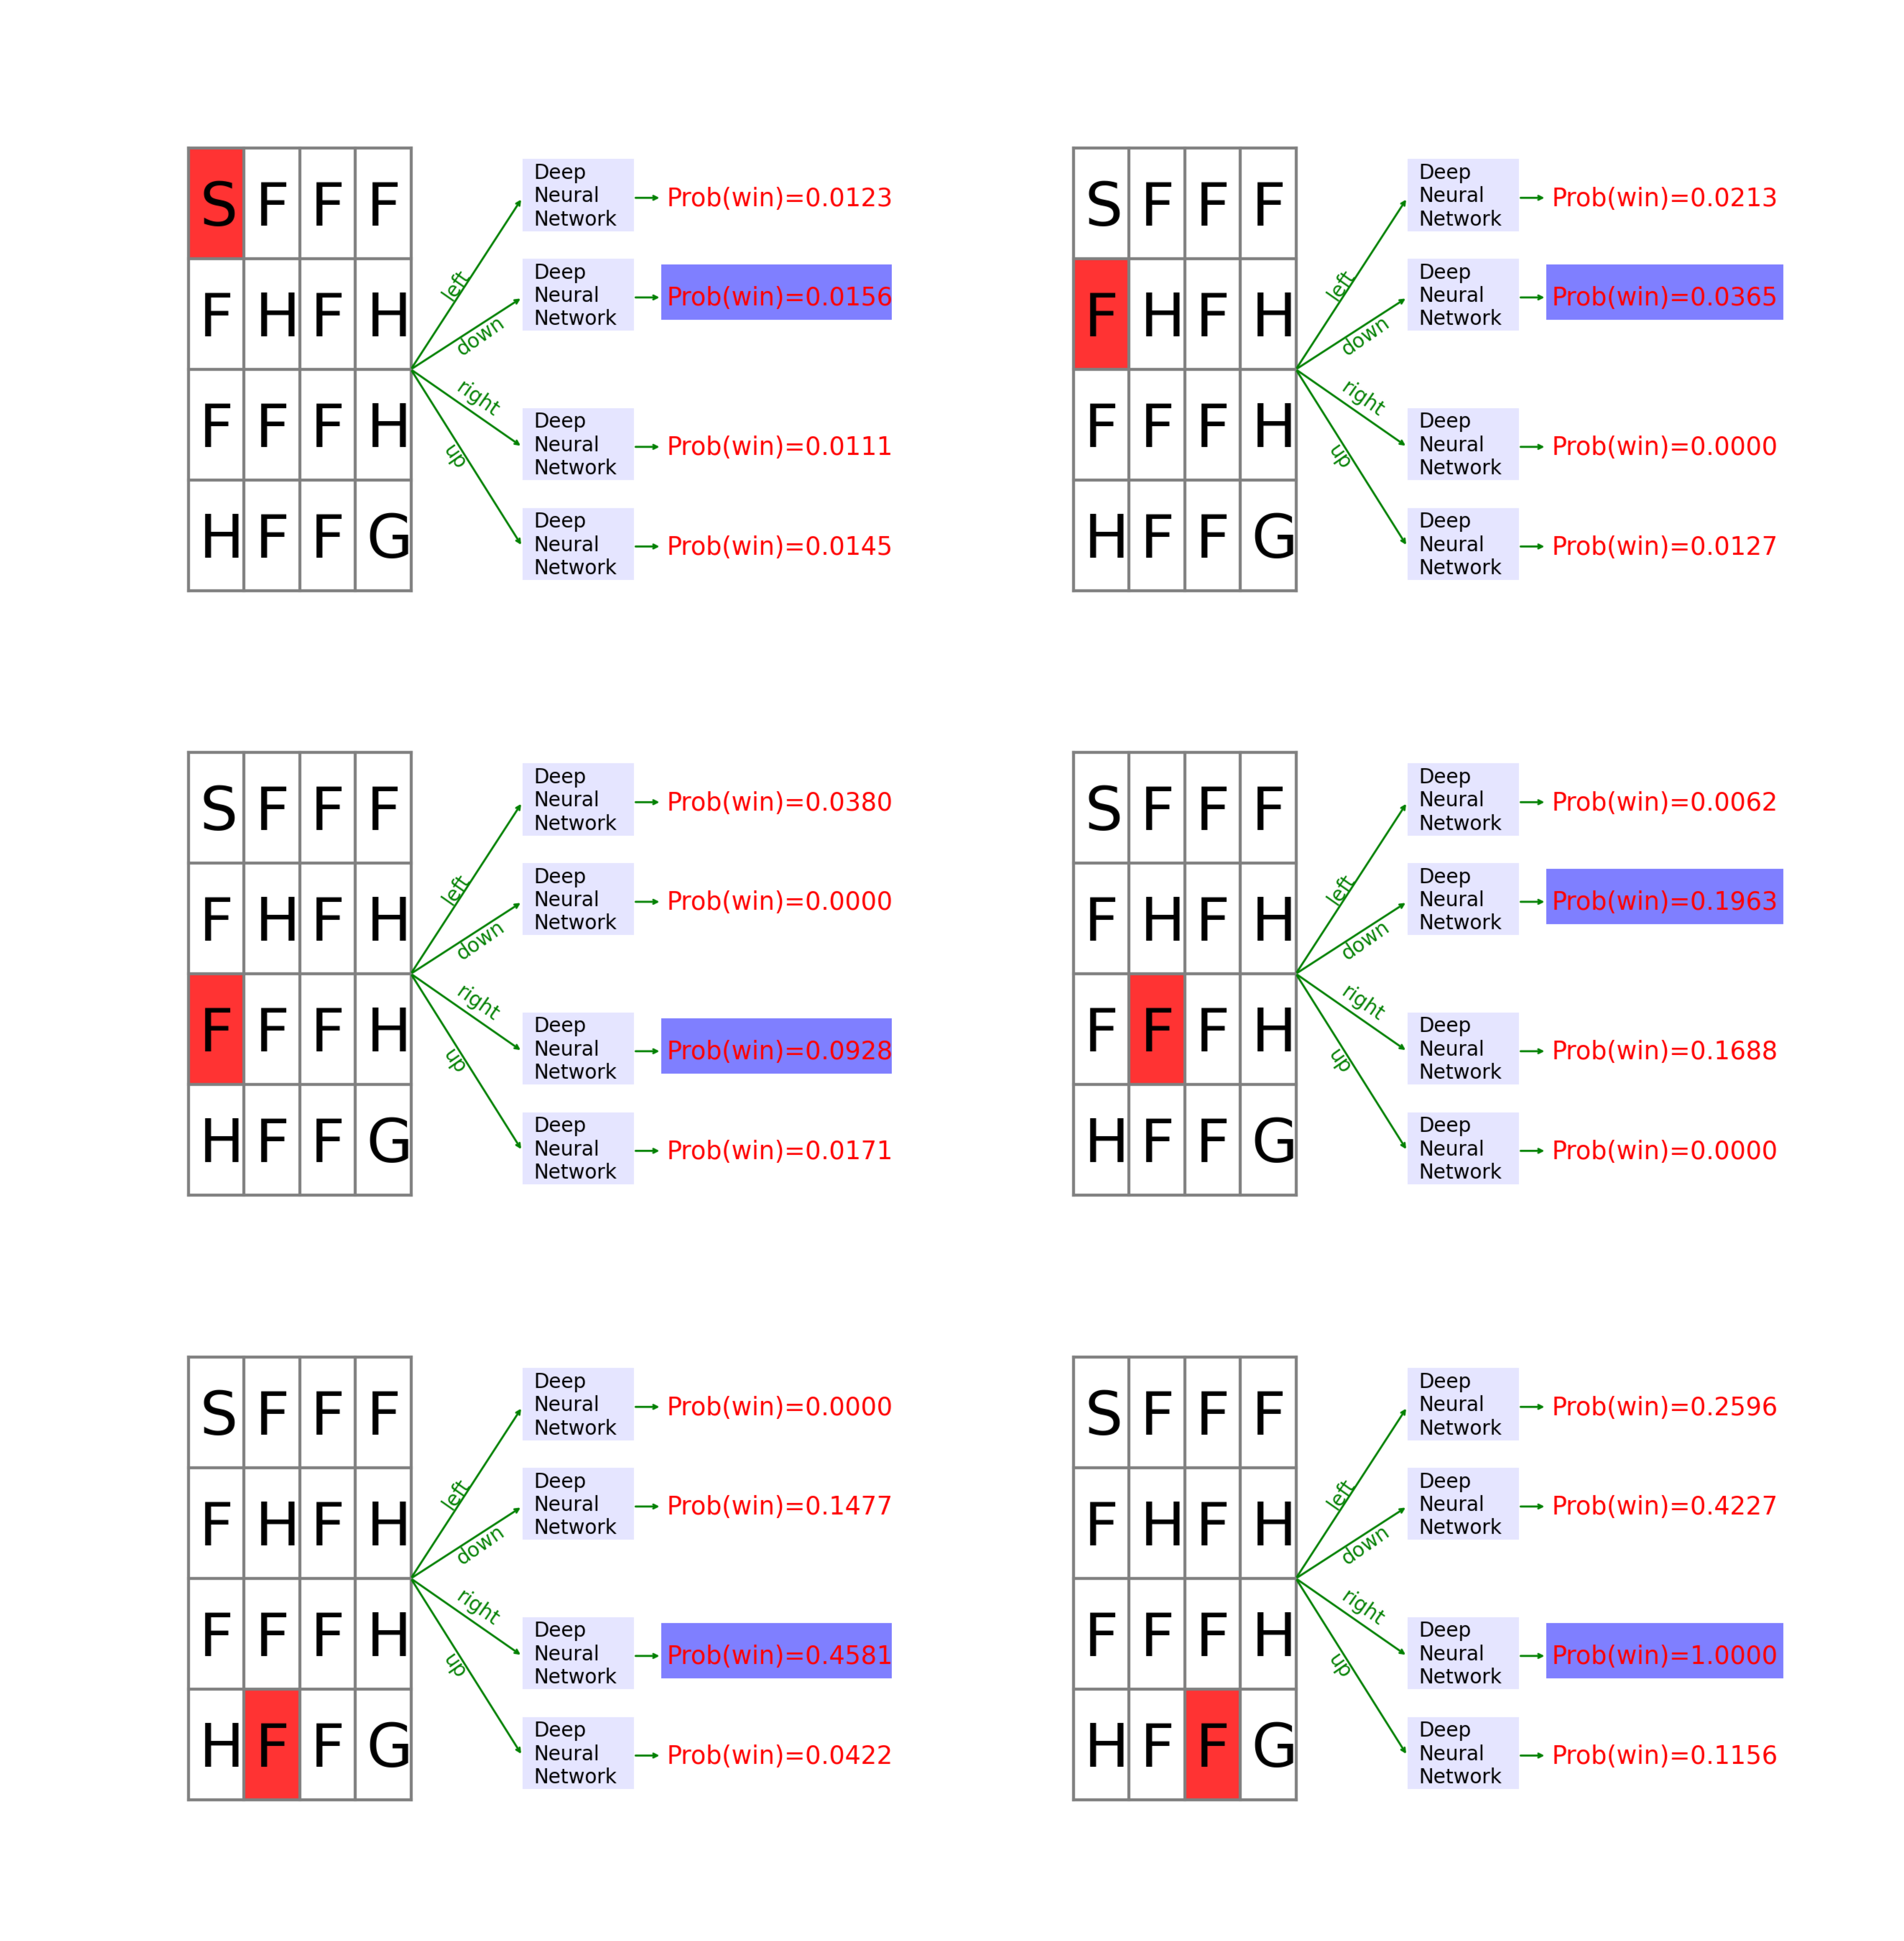

In [21]:
from matplotlib import pyplot as plt

pics=["03","13","23","33","43","53"]
plt.figure(figsize=(28,30),dpi=200)
for i in range(6):
    plt.subplot(3,2,i+1)
    p=f"files/ch10/frozen_stage{pics[i][0]}step{pics[i][1]}.png"
    frame=PIL.Image.open(p)
    plt.imshow(frame)
    plt.axis('off')
plt.subplots_adjust(bottom=0.001,right=0.999,top=0.999,
        left=0.001, hspace=-0.26,wspace=-0.12)
plt.savefig("files/ch10/frozen_stages.png")

# 10.7 Exercises

In [22]:
# answer to question 10.4
from tensorflow.keras.models import Sequential
from random import choice
import pickle
from tensorflow.keras.layers import Dense
import numpy as np
from pprint import pprint

X = np.array(X).reshape((-1, 20))
y = np.array(y).reshape((-1, 1))
# Create a model
model = Sequential()
model.add(Dense(100,activation='relu',
                input_shape=(20,)))
model.add(Dense(50,activation='relu'))
model.add(Dense(25,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',
                   optimizer='adam', 
                   metrics=['accuracy'])
# Train the model for 50 epochs
model.fit(X,y,epochs=50,verbose=0)
model.save('files/ch10/trained_frozen2.h5')

In [23]:
# answer to question 10.5
action0=onehot_encoder(0, 4)
action1=onehot_encoder(1, 4)
action2=onehot_encoder(2, 4)
action3=onehot_encoder(3, 4)
# save the predictions in each step
predictions=[]
state=env.reset()
env.render()
while True:
    # Convert state and action into onehots 
    state_arr=onehot_encoder(state, 16)
    # Predict the probability of winning 
    sa0=np.concatenate([state_arr,action0],axis=1)    
    sa1=np.concatenate([state_arr,action1],axis=1)  
    sa2=np.concatenate([state_arr,action2],axis=1)  
    sa3=np.concatenate([state_arr,action3],axis=1)
    sa=np.concatenate([sa0,sa1,sa2,sa3],axis=0)
    prediction=model.predict(sa)
    action=np.argmax(prediction)
    predictions.append(prediction)
    print(action)
    new_state,reward,done,info=env.step(action)
    env.render()
    print(new_state,reward,done,info) 
    state=new_state
    if done==True:
        break


SFFF
FHFH
FFFH
HFFG
1/1 [==============================] - 0s 64ms/step
1
  (Down)
SFFF
FHFH
FFFH
HFFG
4 0.0 False {'prob': 1.0}
1/1 [==============================] - 0s 19ms/step
1
  (Down)
SFFF
FHFH
FFFH
HFFG
8 0.0 False {'prob': 1.0}
1/1 [==============================] - 0s 18ms/step
2
  (Right)
SFFF
FHFH
FFFH
HFFG
9 0.0 False {'prob': 1.0}
1/1 [==============================] - 0s 17ms/step
2
  (Right)
SFFF
FHFH
FFFH
HFFG
10 0.0 False {'prob': 1.0}
1/1 [==============================] - 0s 20ms/step
1
  (Down)
SFFF
FHFH
FFFH
HFFG
14 0.0 False {'prob': 1.0}
1/1 [==============================] - 0s 19ms/step
2
  (Right)
SFFF
FHFH
FFFH
HFFG
15 1.0 True {'prob': 1.0}
